In [37]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython.core.display import display
from PIL import Image
from matplotlib.ticker import NullLocator
import numpy as np
import glob
import pandas as pd
import json
import os
from sklearn import preprocessing
from skimage.metrics import structural_similarity as ssim  # Need >= Version 0.16.1

game_titles = {
    "shuffleKeys_game": "Switching Mappings Game",
    "contingency_game": "Contingency Game",
    "contingency_game_r0": "Contingency Game (Agent Placement is Constant Among Each Level)",
    "contingency_game_shuffled": "Switching Mappings Game",
    "logic_game": "Logic Game",
    "logic_extended_game": "Ext Logic",
    "change_agent_game": "Switching Embodiments Game"
}

agent_titles = {'human': 'Human', 'self_class': 'Self Class', 'dqn_training': 'DQN',
                'random': 'Random', 'a2c_training': "A2C", 'trpo_training': 'TRPO', 'ppo2_training': 'PPO2',
                'acer_training': 'ACER'}

agent_types = ["self_class"]
game_types = ["contingency_game", ]#"contingency_game", "change_agent_game", "contingency_game_shuffled"]


def combine_heatmaps(game_name, normalized=False, comparison=False):
    agent_types = ["self_class"]
    images = []

    for i in range(len(agent_types)):
        if normalized:
            if comparison:
                if agent_types[i] == 'human':
                    continue
                path = "../data/heatmaps/comparisons_normalized_avg/" + game_name + "/{}.jpg".format(agent_types[i])
            else:
                path = "../data/heatmaps/" + game_name + "_normalized_avg/" + agent_types[i] + "/" + "*.jpg"
        else:
            if comparison:
                if agent_types[i] == 'human':
                    continue
                path = "../data/heatmaps/comparisons_avg/" + game_name + "/{}.jpg".format(agent_types[i])
            else:
                path = "../data/heatmaps/" + game_name + "_avg/" + agent_types[i] + "/" + "*.jpg"
        if len(glob.glob(path)) == 0:  # if one of the image files do not exist
            print("Cannot concatanate: File " + path + " does not exist.")
            return
        images.append(Image.open(glob.glob(path)[0]))

    if not comparison:
        h1 = get_concat_v(images[7], images[0])
        h2 = get_concat_v(images[2], images[3])
        h3 = get_concat_v(images[1], images[6])
        h4 = get_concat_v(images[5], images[4])
    else:
        h1 = get_concat_v(images[2], images[3])
        h2 = get_concat_v(images[1], images[4])
        h3 = get_concat_v(images[0], images[5])
        h4 = images[6]

    combined = get_concat_h(h1, h2)
    combined = get_concat_h(combined, h3)
    combined = get_concat_v(combined, h4) if comparison else get_concat_h(combined, h4)
    display(combined)

    path = "../data/heatmaps/concatenated_heatmaps_compare/" if comparison else "../data/heatmaps/concatenated_heatmaps/"
    if not os.path.exists(path):
        os.makedirs(path)

    if normalized:
        filename = path + game_name + "_norm_concat.jpg"
        combined.save(filename, quality=100)
    else:
        filename = path + game_name + "_concat.jpg"
        combined.save(filename, quality=100)


# concatanate vertically
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst


# concatanate horizontally
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def plot_heatmap(normalise, state_counts, file, game_type, agent_type, _title, avg=False):
    if normalise:
        state_counts = preprocessing.normalize(state_counts)

    plt.imshow(state_counts.T, cmap='viridis')
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                        hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    base = os.path.basename(file)

    if normalise and avg and _title:  # Normalized avg. with title
        path = "../data/heatmaps/" + game_type + "_normalized_avg/" + agent_type + "/"
        title = agent_titles[agent_type] + " (Norm. Avg.)"
    elif normalise and avg and not _title:  # Normalized avg. without title
        path = "../data/heatmaps/" + game_type + "_normalized_avg/" + agent_type + "_titleless/"
    elif normalise and not avg and _title:  # Normalized with title
        path = "../data/heatmaps/" + game_type + "_normalized/" + agent_type + "/"
        title = agent_titles[agent_type] + " (Norm.)"
    elif avg and not _title and not normalise:  # Titleless avg. (for comparison)
        path = "../data/heatmaps/" + game_type + "_avg/" + agent_type + "_titleless/"
    elif avg and _title and not normalise:  # Avg. with title
        path = "../data/heatmaps/" + game_type + "_avg/" + agent_type + "/"
        title = agent_titles[agent_type] + " (Avg.)"
    else:  # Normal with title
        path = "../data/heatmaps/" + game_type + "/" + agent_type + "/"
        title = agent_titles[agent_type]

    if not os.path.exists(path):
        os.makedirs(path)

    if _title:
        plt.title(title, fontweight='bold', fontsize=18)
        filename = path + os.path.splitext(base)[0] + '_heatmap.jpg'
    else:
        filename = path + os.path.splitext(base)[0] + '_titleless_heatmap.jpg'

    plt.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=1200)
    plt.show()


def make_heatmap(game_type, agent_type, normalise=False):
    df_r = pd.DataFrame()
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json") + glob.glob(
            "../data/" + game_type + "/" + agent_type + "/*.json")
    if len(files) == 0:
        return False

    seed = 0
    curr_file_count = 0
    state_counts_sum = []  # Sum of state counts of all seeds
    state_counts_seed = []  # Sum of state counts of a single seed
    for i, file in enumerate(sorted(files, key=os.path.getmtime)):
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]
        map = data.get("data")["map"]

        level_amt = 100
        width = len(map[0][0])
        height = len(map[0])

        state_counts = np.zeros((width, height))  # State counts of 100 levels

        if i == 0:
            state_counts_seed = np.zeros((width, height))
            state_counts_sum = np.zeros((width, height))

        # read encountered states
        for level in range(level_amt):
            if len(self_locs[level]) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range(action_amt):
                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                state_counts[x, y] += 1

        # rotate the matrix
        state_counts = np.rot90(state_counts)

        curr_file_count += 1
        if curr_file_count == 20:
            plot_heatmap(normalise, state_counts_seed, "seed_" + str(seed), game_type, agent_type, _title=True)
            state_counts_seed = np.zeros((width, height))
            curr_file_count = 0
            seed += 1

        if agent_type == 'human':
            plot_heatmap(normalise, state_counts_seed, file.split('_')[0] + str(seed), game_type, agent_type,
                         _title=True)

        state_counts_sum += state_counts
        state_counts_seed += state_counts

    # Plot the average of all seeds:
    #state_counts = np.zeros((width, height))
    #for i in range( len(state_counts_sum) ):
    #    state_counts = np.add(state_counts, state_counts_sum[i])

    # Print one titled and one titleless (titleless for comparison).
    plot_heatmap(normalise, state_counts_sum, "seeds_combined", game_type, agent_type, avg=True, _title=True)
    plot_heatmap(normalise, state_counts_sum, "seeds_combined", game_type, agent_type, avg=True, _title=False)
    return True

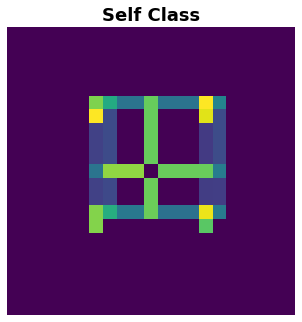

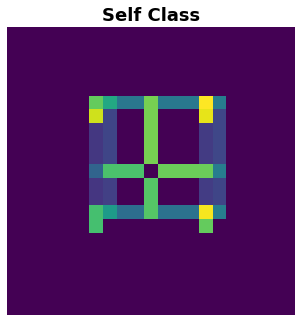

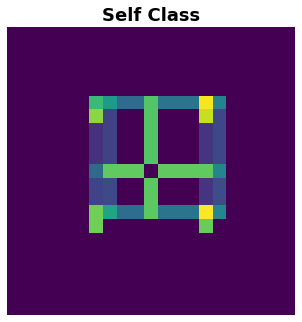

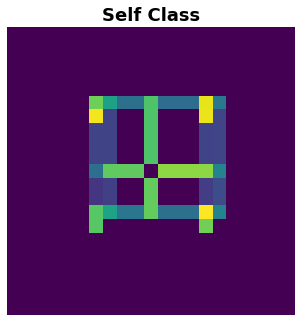

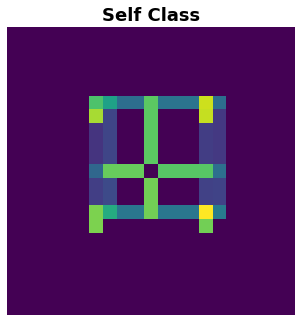

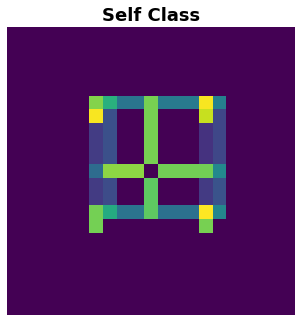

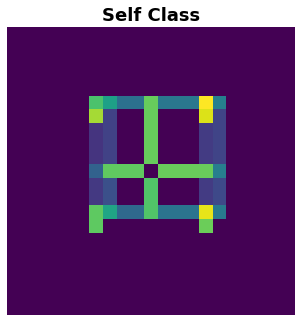

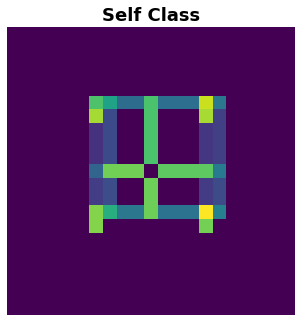

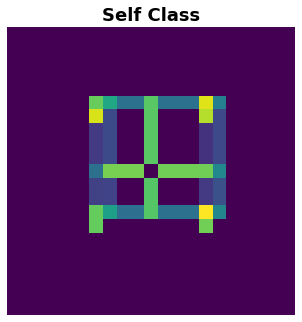

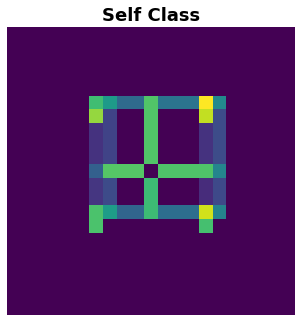

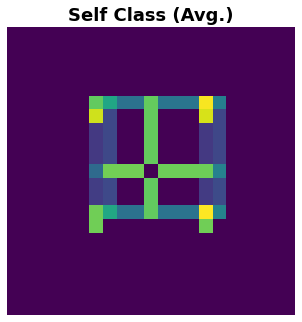

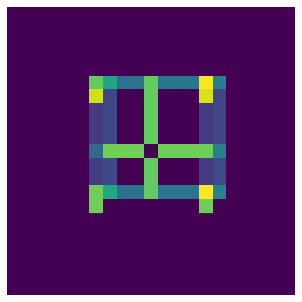

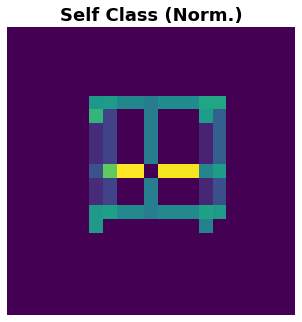

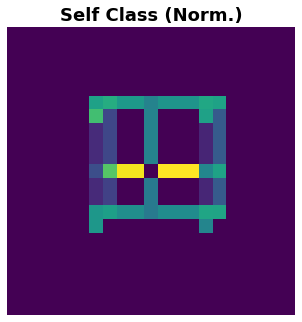

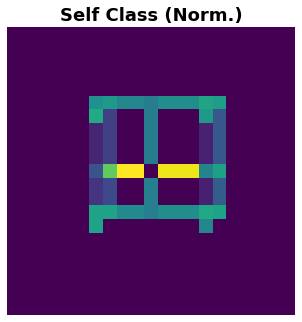

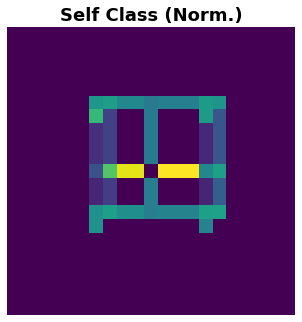

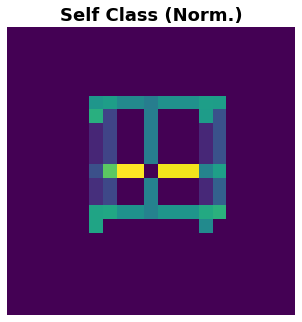

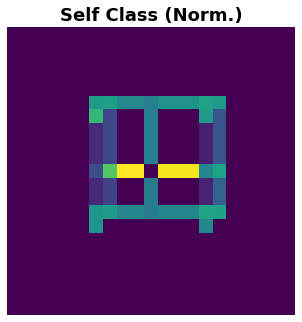

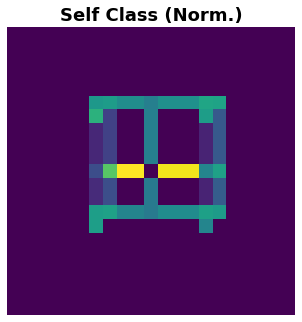

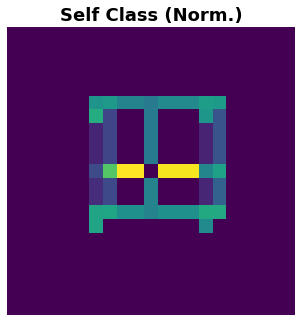

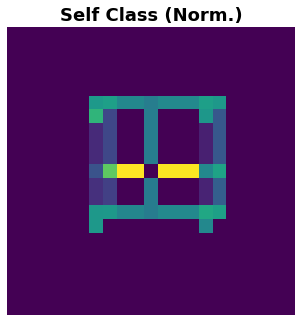

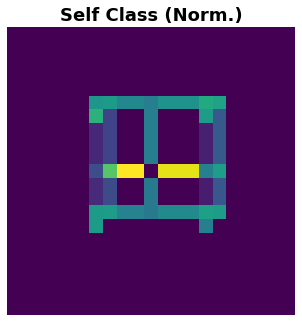

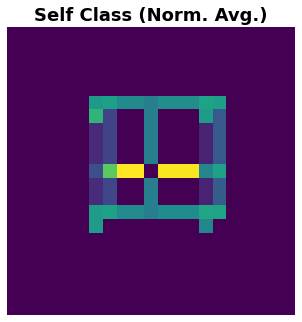

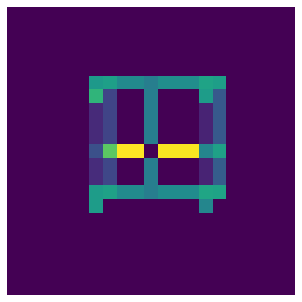

In [38]:
# make heatmap for all game types and agent types

for game in game_types:
    for agent in agent_types:
        make_heatmap(game, agent)
        make_heatmap(game, agent, True) # make normalized heatmaps

    #combine_heatmaps(game)
    #combine_heatmaps(game, True) # combine normalized heatmaps

    # Combine comparisons
    #combine_heatmaps(game, normalized=False, comparison=True)
    #combine_heatmaps(game, normalized=True, comparison=True)  # combine normalized heatmaps


In [ ]:
make_heatmap("logic_game", "human")

In [ ]:
# Source: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err


# Source: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
def compare_images(imageA, imageB, game_type, agent_type, title, folder_appx):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)  # Mean Squared Error (0 = same image)
    s = ssim(imageA, imageB, multichannel=True)  # Structural Similarity (1 = same image). This one is more precise

    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s) + " \n(" + title + ")")

    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap=plt.cm.gray)
    plt.axis("off")

    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap=plt.cm.gray)
    plt.axis("off")

    # show the images
    plt.show()

    path = "../data/heatmaps/comparisons_{}/".format(folder_appx) + game_type + "/"
    if not os.path.exists(path):
        os.makedirs(path)

    filename = path + agent_type + ".jpg"

    fig.savefig(filename, format='jpg', dpi=1200)

In [ ]:
# Compare human heatmap to other agent types:
agent_types = ("dqn_training", "random", "self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training")

for game in game_types:
    for agent in agent_types:
        pathA = "../data/heatmaps/" + game + "_avg/" + "human" + "_titleless" + "/" + "*.jpg"
        pathB = "../data/heatmaps/" + game + "_avg/" + agent + "_titleless" + "/" + "*.jpg"

        imgA = mpimg.imread(glob.glob(pathA)[0])
        imgB = mpimg.imread(glob.glob(pathB)[0])
        compare_images(imgA, imgB, game_type=game, agent_type=agent,
                       title="Human vs. " + agent_titles[agent] + " (" + game_titles[game] + ")", folder_appx='avg')

for game in game_types:
    for agent in agent_types:
        pathA = "../data/heatmaps/" + game + "_normalized_avg/" + "human" + "_titleless" + "/" + "*.jpg"
        pathB = "../data/heatmaps/" + game + "_normalized_avg/" + agent + "_titleless" + "/" + "*.jpg"

        imgA = mpimg.imread(glob.glob(pathA)[0])
        imgB = mpimg.imread(glob.glob(pathB)[0])
        compare_images(imgA, imgB, game_type=game, agent_type=agent,
                       title="Human vs. " + agent_titles[agent] + " (" + game_titles[game] + ")",
                       folder_appx='normalized_avg')